In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp

import distrax
from distrax import HMM

import optax

import tensorflow_probability as tfp
from tensorflow_probability.substrates import jax as tfpj

import scipy.stats as stats

2025-01-26 13:19:27.065481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737897567.082886   32644 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737897567.088050   32644 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
true_rates = np.random.randint(1, 50, size=4)
true_durations = np.random.randint(10, 50, size=4)
print(true_rates, true_durations)

[41 21 17  1] [36 25 34 44]


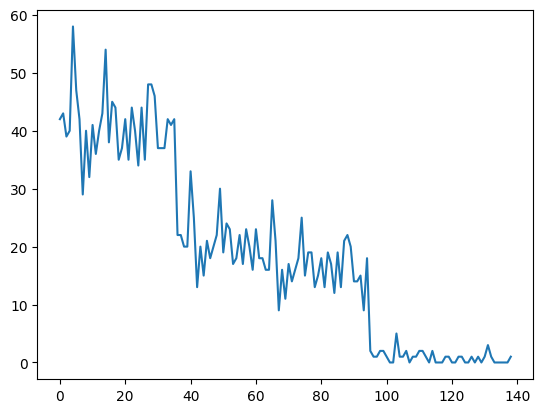

In [4]:
rand_state = 0
counts_ts = jnp.concatenate([
  stats.poisson(r).rvs(d, random_state=rand_state)
  for r, d in zip(true_rates, true_durations)
]).astype(jnp.float32)

plt.plot(counts_ts)

#### With known number of states K=4
- use a uniform prior for the initial state distribution $z_1 \sim Categorical({1/K, ..., 1/K})$
- set the transition matrix with a transition probability of p,  $z_t | z_{t-1} \sim Categorical({1-p if z_t = z_{t-1}, p/(K-1) otherwise})$


In [56]:
def latent_state_probs(num_states, max_num_state, transition_prob):
  def init_state_prob_fn(s):
    return jnp.where(s <= num_states, 1.0 / num_states, 0.0)
  
  states = jnp.arange(1, max_num_state+1)
  initial_state_probs = jax.vmap(init_state_prob_fn)(states)

  def transition_prob_fn(s1, s2):
    return jnp.where(
      (s1 <= num_states) & (s2 <= num_states),
      jnp.where(s1 == s2, 1 - transition_prob, transition_prob / (num_states - 1)),
      jnp.where(s1 == s2, 1.0, 0.0)
    )
  
  transition_probs = jax.vmap(transition_prob_fn, in_axes=(0, None))(states, states)

  return initial_state_probs, transition_probs

predef_num_states = 4
max_num_state = predef_num_states
transition_prob = 0.1

initial_state_probs, transition_probs = latent_state_probs(predef_num_states, max_num_state, transition_prob)
print(initial_state_probs)
print(transition_probs)

[0.25 0.25 0.25 0.25]
[[0.9        0.03333334 0.03333334 0.03333334]
 [0.03333334 0.9        0.03333334 0.03333334]
 [0.03333334 0.03333334 0.9        0.03333334]
 [0.03333334 0.03333334 0.03333334 0.9       ]]


In [57]:
def make_hmm(log_rates, initial_state_probs, transition_probs):
  return HMM(
    obs_dist=tfpj.distributions.Poisson(log_rate=log_rates),
    init_dist=distrax.Categorical(probs=initial_state_probs),
    trans_dist=distrax.Categorical(probs=transition_probs),
  )
  

In [58]:
rng_key = jax.random.PRNGKey(1)
rng_key, rng_normal = jax.random.split(rng_key, 2)

trainable_log_rates = jnp.log(jnp.mean(counts_ts)) + jax.random.normal(rng_normal, (predef_num_states,))
print('initial rates:', jnp.exp(trainable_log_rates))
hmm = make_hmm(trainable_log_rates, initial_state_probs, transition_probs)

initial rates: [14.695793 21.20743   8.742283  7.391826]


In [80]:
# log-normal prior on the rates
poisson_rates_prior = tfpj.distributions.LogNormal(jnp.log(jnp.mean(counts_ts)), jnp.log(2))
# poisson_rates_prior = tfpj.distributions.LogNormal(5, 5)
# poisson_rates_prior = distrax.LogStddevNormal(5., 5.)
poisson_rates_prior, poisson_rates_prior.loc, poisson_rates_prior.scale

(<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>,
 Array(2.9314814, dtype=float32),
 Array(0.6931472, dtype=float32, weak_type=True))

##### Fit with gradient descent

fit poisson rates only

fitted_rates [20.610348  40.94547   16.483099   1.0021462]
true_rates [41 21 17  1]


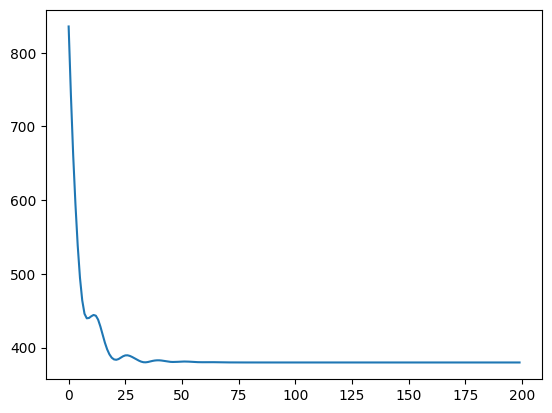

In [82]:
def loss_fun(params, initial_state_probs, transition_probs):
  """ Negative log-likelihood + prior over the poisson rates """

  hmm = make_hmm(params['log_rates'], initial_state_probs, transition_probs)
  return -(
    poisson_rates_prior.log_prob(jnp.exp(params['log_rates'])).sum() +
    hmm.forward(counts_ts)[0]
  )

def update(opt_state, params, initial_state_probs, transition_probs):
  loss, grad = jax.value_and_grad(loss_fun)(params, initial_state_probs, transition_probs)
  updates, opt_state = optimizer.update(grad, opt_state)
  params = optax.apply_updates(params, updates)
  return (opt_state, params), loss

def fit(params, initial_state_probs, transition_probs, num_steps):
  opt_state = optimizer.init(params)

  def train_step(opt_state_params, step):
    return update(*opt_state_params, initial_state_probs, transition_probs)
  
  (opt_state, params), losses = jax.lax.scan(train_step, (opt_state, params), jnp.arange(num_steps))
  
  return params, losses

params = {
  'log_rates': trainable_log_rates,
}

lr = 1e-1
num_steps = 200

optimizer = optax.adam(lr)
params, losses = fit(params, initial_state_probs, transition_probs, num_steps)

fitted_log_rates = params['log_rates']
fitted_hmm = make_hmm(fitted_log_rates, initial_state_probs, transition_probs)
fitted_rates = jnp.exp(fitted_log_rates)
print('fitted_rates', fitted_rates)
print('true_rates', true_rates)

plt.plot(losses)
plt.show()

In [83]:
from itertools import cycle, product
import random

colors_list=['k','b','g','r'] # list of basic colors
styles_list=['-','--','-.',':'] # list of basic linestyles
ls_c = list(product(styles_list, colors_list))
random.shuffle(ls_c)
ls_color_cycler = cycle(ls_c)

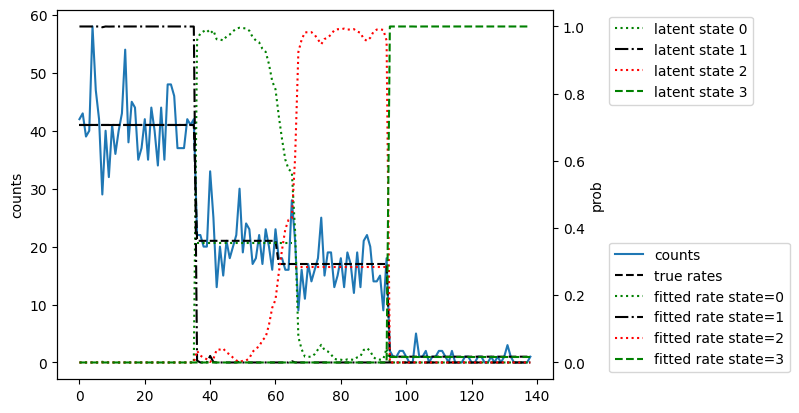

In [84]:
_, _, obsrv_posterior_probs, _ = fitted_hmm.forward_backward(counts_ts)

fig, ax = plt.subplots()
ax.plot(counts_ts, label='counts')

true_rates_ts = jnp.concatenate([jnp.full(d, r) for r, d in zip(true_rates, true_durations)])
ax.plot(true_rates_ts, label='true rates', c='k', ls='--')

ax.set_ylabel('counts')

ax1 = ax.twinx()
for i in range(predef_num_states):
  ls, c = next(ls_color_cycler)
  ax1.plot(obsrv_posterior_probs[:, i], label=f'latent state {i}', c=c, ls=ls)

  is_max_prob = jnp.argmax(obsrv_posterior_probs, axis=1) == i
  fitted_state_rate_ts  = jnp.where(is_max_prob, fitted_rates[i], jnp.nan)
  ax.plot(fitted_state_rate_ts, c=c, ls=ls, label=f'fitted rate state={i}')

ax1.set_ylabel('prob')

ax.legend()
ax1.legend()

sns.move_legend(ax, "lower left", bbox_to_anchor=(1.1, 0))
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1.1, 1))
plt.show()


/home/lysonn/.venvs/base/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


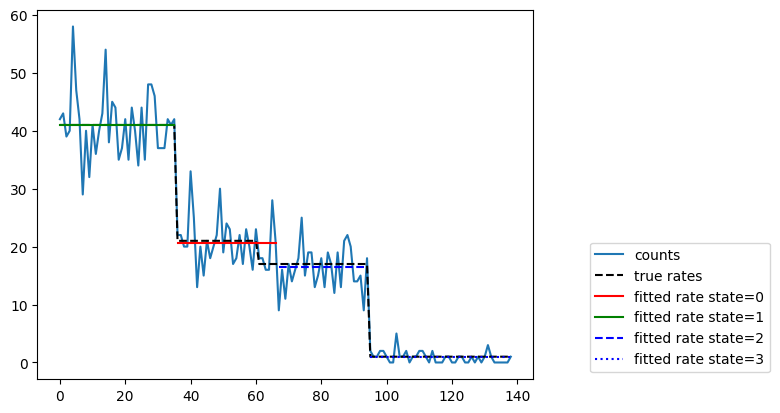

In [85]:
most_probable_states = fitted_hmm.viterbi(counts_ts)
most_probable_rates = jax.vmap(lambda s: fitted_rates[s].astype(jnp.float32))(most_probable_states)

fig, ax = plt.subplots()
ax.plot(counts_ts, label='counts')
ax.plot(true_rates_ts, label='true rates', c='k', ls='--')

for i in range(predef_num_states):
  ls, c = next(ls_color_cycler)
  ax.plot(jnp.where(most_probable_states == i, most_probable_rates, jnp.nan), c=c, ls=ls, label=f'fitted rate state={i}')

ax.legend()
sns.move_legend(ax, "lower left", bbox_to_anchor=(1.1, 0))
plt.show()


#### Find the best number of states, K

fit hmms for each K=(0,...,10), select best model based on marginal likelihood (for lowest number of states)

In [86]:
max_num_state = 10
states = jnp.arange(1, max_num_state+1)

transition_prob = 0.1

batch_initial_state_probs, batch_transition_probs = jax.vmap(latent_state_probs, in_axes=(0, None, None))(states, max_num_state, transition_prob)
print(batch_initial_state_probs.shape, batch_transition_probs.shape)
print('n_states=5\n', batch_initial_state_probs[5], '\n', batch_transition_probs[5])

(10, 10) (10, 10, 10)
n_states=5
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.         0.         0.         0.        ] 
 [[0.9  0.02 0.02 0.02 0.02 0.02 0.   0.   0.   0.  ]
 [0.02 0.9  0.02 0.02 0.02 0.02 0.   0.   0.   0.  ]
 [0.02 0.02 0.9  0.02 0.02 0.02 0.   0.   0.   0.  ]
 [0.02 0.02 0.02 0.9  0.02 0.02 0.   0.   0.   0.  ]
 [0.02 0.02 0.02 0.02 0.9  0.02 0.   0.   0.   0.  ]
 [0.02 0.02 0.02 0.02 0.02 0.9  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [87]:
rng_key, rng_normal = jax.random.split(rng_key, 2)


In [88]:
trainable_log_rates = jnp.log(jnp.mean(counts_ts)) + jax.random.normal(rng_normal, (max_num_state,))

params = {
  'log_rates': trainable_log_rates,
}

lr = 1e-1
num_steps = 200

optimizer = optax.adam(lr)
batch_params, batch_losses = jax.vmap(fit, in_axes=(None, 0, 0, None))(params, batch_initial_state_probs, batch_transition_probs, num_steps)
fitted_batch_log_rates = batch_params['log_rates']
fitted_batch_rates = jnp.exp(fitted_batch_log_rates)

print('batch_losses.shape', batch_losses.shape)


batch_losses.shape (10, 200)


In [95]:
from pprint import pprint
print('true_rates', true_rates)
print('fitted_batch_rates', fitted_batch_rates.shape) 

for i in range(max_num_state):
  print(i+1, fitted_batch_rates[i, :i+1])


true_rates [41 21 17  1]
fitted_batch_rates (10, 10)
1 [18.748638]
2 [27.01313    1.0024134]
3 [40.91275    1.0021362 18.438114 ]
4 [40.933296    2.0560727   0.95392525 18.457806  ]
5 [40.948605   2.2568064  0.9789739 20.620375  16.48706  ]
6 [20.531818    2.326961    0.98707473 20.532366   16.430874   40.948185  ]
7 [20.451733  16.398752  20.45125   40.87166   20.4511    40.871754
  1.0021918]
8 [20.513405  20.50447   20.503563  16.420458  16.391665  40.948494
  1.0021838 16.453783 ]
9 [16.445932  16.451607  16.451595  20.618866  20.618773  40.949287
  1.0021794 16.450527  16.493048 ]
10 [40.874504  16.397017  16.397085  20.521687  20.521706  40.874424
  1.0021861 20.521473  16.466555  16.395695 ]


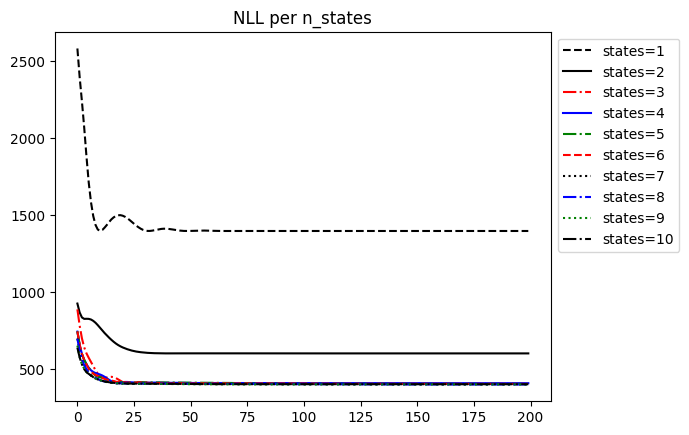

In [90]:
for i in range(max_num_state):
  ls, c = next(ls_color_cycler)
  plt.plot(batch_losses[i], label=f'states={i+1}', c=c, ls=ls)
plt.legend()
plt.title('NLL per n_states')
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.show()

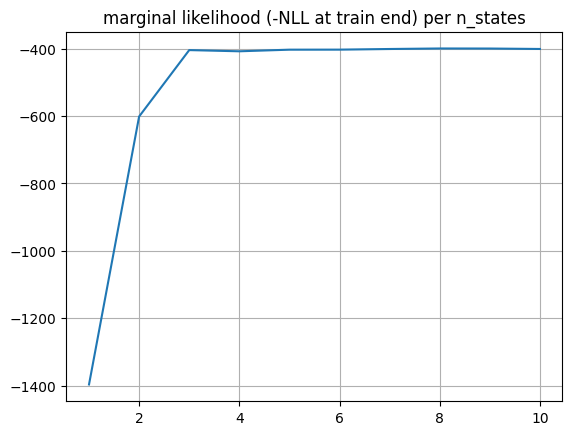

In [91]:
plt.plot(range(1, max_num_state+1), -batch_losses[:, -1])
plt.title('marginal likelihood (-NLL at train end) per n_states')
plt.grid()
plt.show()

In [92]:
def get_posterior_marginals(fitted_log_rates, initial_state_probs, transition_probs):
  fitted_hmm = make_hmm(fitted_log_rates, initial_state_probs, transition_probs)
  _, _, obsrv_posterior_probs, _ = fitted_hmm.forward_backward(counts_ts)
  return obsrv_posterior_probs

batch_obsrv_posterior_probs = jax.vmap(get_posterior_marginals, in_axes=(0, 0, 0))(
  fitted_batch_log_rates, batch_initial_state_probs, batch_transition_probs
)
batch_obsrv_posterior_probs.shape

(10, 139, 10)

In [93]:
batch_most_prob_states = batch_obsrv_posterior_probs.argmax(axis=-1)
batch_most_prob_states.shape

(10, 139)

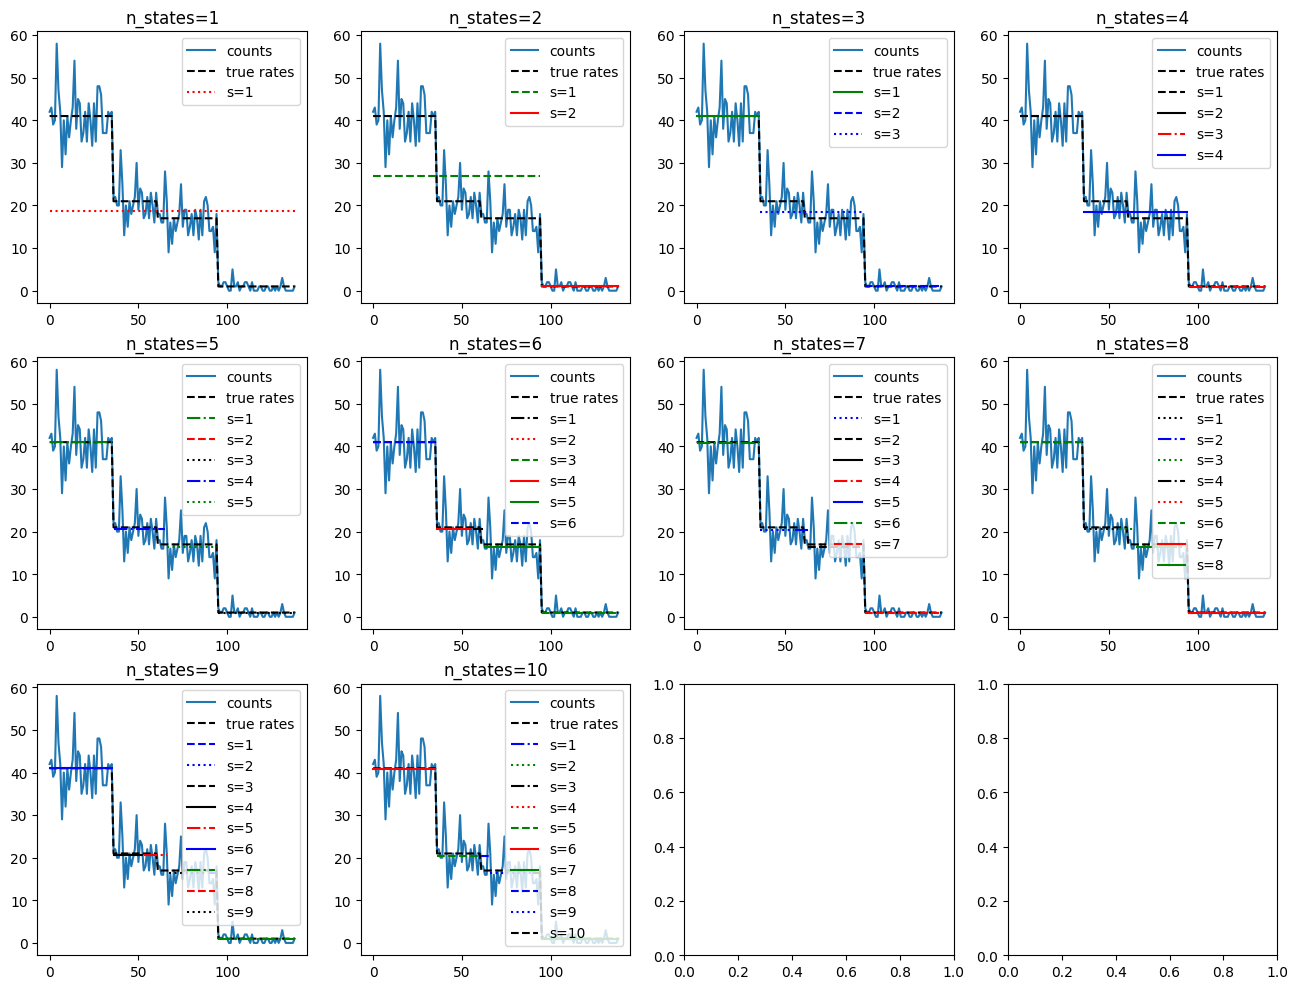

In [94]:
n_cols = int(np.ceil(np.sqrt(max_num_state)))
n_rows = int(np.ceil(max_num_state / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axs = axs.flatten()

for n_states, ax in zip(range(1, max_num_state+1), axs):
  ax.plot(counts_ts, label='counts')
  ax.plot(true_rates_ts, label='true rates', c='k', ls='--')

  for i in range(n_states):
    ls, c = next(ls_color_cycler)

    is_max_prob = batch_most_prob_states[n_states-1] == i
    fitted_state_rate_ts  = jnp.where(is_max_prob, fitted_batch_rates[n_states-1, i], jnp.nan)
    ax.plot(fitted_state_rate_ts, c=c, ls=ls, label=f's={i+1}')

  ax.legend()
  ax.set_title(f'n_states={n_states}')